This notebook shows some examples of ways to select and plot data from our analyses presented in ["Transcriptomic correlates of electrophysiological and morphological diversity within and across neuron types"](https://www.biorxiv.org/content/early/2019/01/18/524561).

We've written this mainly for people with little or no coding experience. You can start by using the code we already have written as a template, and fill in the gene names or ephys/morphology properties you're interested in learning more about. To run the code, highlight the cell you want and press Shift+Enter.

If you get lost, there's a [nice tutorial](https://mybinder.org/v2/gh/jvns/pandas-cookbook/master?filepath=cookbook%2FA%20quick%20tour%20of%20IPython%20Notebook.ipynb) on using Jupyter Notebook written by Julia Evans.

Please let me know if you find any issues with this notebook or have suggestions for how it could be improved! The goal was for this to be approachable and easy to use, so if you're confused that probably means I should have written it better. Please let me know! You can reach me at <claire.bomkamp@alumni.ubc.ca>.

# Setup

If you're running this notebook off of Binder, just run the cell below without changing anything.

Otherwise, make sure you have Online Tables 1-4. They should be saved as "online_table1.csv", "online_table2.csv", etc.  
Enter the path where you saved the files:

In [35]:
data_path = './Data/'

path_1 = data_path + 'online_table1.csv'
path_2 = data_path + 'online_table2.csv'
path_3 = data_path + 'online_table3.csv'
path_4 = data_path + 'online_table4.csv'

Run the next cell to load the data and get everything set up:  
- Import libraries  
- Load data
- Map between ephys/morphology property names and abbreviations
- Define functions for making scatter plots and fitting models 

In [37]:
print('importing libraries')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

matplotlib.style.use('seaborn-ticks')
color_exc = '#006DDB'
color_inh = '#920000'

print('loading data')
scores = pd.read_csv(path_1, index_col = 0)
scores_all = pd.read_csv(path_2, index_col = 0)
ephys = pd.read_csv(path_3, index_col = 0, low_memory = False)
morph = pd.read_csv(path_4, index_col = 0, low_memory = False)

ephys.index = [str(n) for n in ephys.index]
morph.index = [str(n) for n in morph.index]

tmp = scores_all.drop_duplicates('gene_entrez_id')
tmp.index = tmp.gene_entrez_id.astype(str)
id_to_symbol = tmp.gene_symbol.to_dict()
symbol_to_id = {a:b for b,a in id_to_symbol.items()}

print('naming ephys/morphology properties')
property_labels = {'apamp': 'AP Amplitude', 'ahpamp': 'AHP Amplitude', 'aphw': 'AP Half-width', 
                   'maxfreq': 'Max Firing Frequency', 'tau' : 'Time Constant Tau', 'rmp': 'Resting Membrane Potential',
                   'avg_isi': 'Average Interspike Interval', 'f_i_curve_slope': 'Input-Output Curve Slope',
                   'cap' : 'Capacitance', 'sag': 'Sag', 'ri': 'Input Resistance', 'rheo': 'Rheobase',
                   'adratio': 'Adaptation Ratio', 'apthr': 'AP Threshold', 
                   'latency' : 'Latency', 'isi_cv' : 'ISI CoV', 
                   'average_bifurcation_angle_local' : 'Bifurcation Angle', 'max_branch_order' : 'Max Branch Order', 
                   'branchiness' : 'Branchiness', 'total_length' : 'Total Length',
                   'total_volume' : 'Total Volume', 'soma_surface' : 'Soma Surface', 
                   'E_PC1': 'Electrophysiology PC1','E_PC2': 'Electrophysiology PC2', 
                   'E_PC3': 'Electrophysiology PC3', 
                   'M_PC1': 'Morphology PC1', 'M_PC2': 'Morphology PC2', 
                   'M_PC3': 'Morphology PC3'}

property_labels_units = {'apamp': 'AP Amplitude (mV)', 'ahpamp': 'AHP Amplitude (mV)', 'aphw': 'AP Half-width (ms)', 
                         'maxfreq': 'Max Firing\nFrequency (Hz)',
                         'tau' : 'Time Constant Tau (ms)', 'rmp': 'Resting Membrane Potential (mV)',
                         'avg_isi': 'Average Interspike Interval (ms)', 'f_i_curve_slope': 'Input-Output Curve\nSlope (Hz/pA)',
                         'cap' : 'Capacitance (pF)', 'sag': 'Sag', 'ri': u'Input Resistance (MΩ)', 'rheo': 'Rheobase (pA)',
                         'adratio': 'Adaptation Ratio', 'apthr': 'AP Threshold (mV)', 
                         'latency' : 'Latency (s)', 'isi_cv' : 'ISI CoV', 
                         'average_bifurcation_angle_local' : 'Bifurcation Angle (degrees)', 'max_branch_order' : 'Max Branch Order', 
                         'branchiness' : u'Branchiness\n(branches/μm)', 'total_length' : u'Total Length (μm)',
                         'total_volume' : u'Total Volume (μm^3)', 'soma_surface' : u'Soma Surface (μm^2)', 
                         'E_PC1': 'Electrophysiology PC1','E_PC2': 'Electrophysiology PC2', 
                         'E_PC3': 'Electrophysiology PC3', 
                         'M_PC1': 'Morphology PC1', 'M_PC2': 'Morphology PC2', 
                         'M_PC3': 'Morphology PC3'}

props_morph = ['average_bifurcation_angle_local', 'branchiness', 'max_branch_order', 'total_length',
               'total_volume', 'soma_surface', 'M_PC1', 'M_PC2', 'M_PC3']
props_all = property_labels.keys()
props_ephys = sorted(list(set(props_all).difference(set(props_morph))))
property_table = pd.DataFrame(list(property_labels.keys()), list(property_labels.values()), columns = ['Abbreviation'])

print('defining functions')

def make_scatter(gene, prop, ax = None, alpha = 0.6, s = 30, log = False, annotate_qvals = True):

    # Set up axes
    if ax == None:
        fig, ax = plt.subplots()    
    if log:
        ax.set_yscale('log')

    # Select data
    if type(gene) == str:
        gene = str(symbol_to_id[gene])
    elif type(gene) == int:
        gene = str(gene)
    df = morph if prop in props_morph else ephys
    line_labels = [{'exc': 1, 'inh': 0}[line.split('__')[-1]] for line in df.columns]
    x = df.loc[gene]        
    y = df.loc[prop]
    line_labels_gene = line_labels
    exc = [n > 0.5 for n in line_labels]
    inh = [n <= 0.5 for n in line_labels]

    # Remove zero values if there are too many
    not_zero = [val > 0 for val in x]
    x = x[not_zero]
    y = y[not_zero]
    exc = [a and b for a, b in zip(exc, not_zero)]
    inh = [a and b for a, b in zip(inh, not_zero)]
    line_labels_gene = [i for (i, v) in zip(line_labels_gene, not_zero) if v]

    # Plot
    x_exc = df.loc[:, exc].loc[gene]
    y_exc = df.loc[:, exc].loc[prop]    
    x_inh = df.loc[:, inh].loc[gene]
    y_inh = df.loc[:, inh].loc[prop]    
    
    fit_all = np.polyfit(x, np.log10(y) if log else y, deg = 1)
    fit_exc = np.polyfit(x_exc, np.log10(y_exc) if log else y_exc, deg = 1)
    fit_inh = np.polyfit(x_inh, np.log10(y_inh) if log else y_inh, deg = 1)
    

    # Draw lines of best fit
    lim_all = pd.Series([x.min(), x.max()])
    lim_exc = pd.Series([x_exc.min(), x_exc.max()])
    lim_inh = pd.Series([x_inh.min(), x_inh.max()])

    for lim, fit, linestyle in zip([lim_all, lim_exc, lim_inh], [fit_all, fit_exc, fit_inh], ['k--', 'k-', 'k-']):
        if log:
            fit_line = 10**(lim * fit[0] + fit[1])
        else:
            fit_line = lim * fit[0] + fit[1]
        ax.plot(lim, fit_line, linestyle, linewidth = 1)
        
    for x_subset, y_subset, color, marker in zip([x_inh, x_exc], [y_inh, y_exc], [color_inh, color_exc], ['o', 'D']):
        ax.scatter(x_subset, y_subset, color = color, s = s, marker = marker, alpha = alpha)
                
    ax.set_xlabel(id_to_symbol[gene] + ' ($log_2$ CPM+1)')
    ax.set_ylabel(property_labels_units[prop])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Annotate p-values for CI, CC, and Int models
    if annotate_qvals:
        if (scores_all[(scores_all.property == prop) & (scores_all.gene_entrez_id == int(gene))]).shape[0] > 0:
            pvals = [np.round(scores_all[(scores_all.property == prop) & (scores_all.gene_entrez_id == int(gene))][pval].values[0], 3) for pval in ['FDR_gene', 'FDR_gene|class_anova', 'FDR_int_anova']]
            ax.annotate('\n'.join([label + ': q=' + str(pval) for label, pval in zip(['CI', 'CC', 'Int'], pvals)]), (1, 1), xycoords = 'axes fraction', ha = 'right', va = 'top')
    
def make_legend(ax, alpha = 0.6, s = 30):
    i = ax.scatter([], [], color = color_inh, marker = 'o', s = s, alpha = alpha)
    e = ax.scatter([], [], color = color_exc, marker = 'D', s = s, alpha = alpha)
    ax.legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(1, 1), loc= 'upper left', frameon = True)

# fit linear models explaining ephys according to gene expression and/or cell class
# this is the same code as in the initial analysis, but modified to return the full models for a single 
    # combination of gene + property (as opposed to a summary table for many genes and properties)

def fit_models(gene, measure, df_input, min_samples = 10):
    
    if type(gene) == str:
        gene = symbol_to_id[gene]
    
    line_labels = [line.split('__')[-1] for line in df_input.columns]    
    gene = str(gene)    
    result_list = []
    output = []
    
    line_labels = pd.DataFrame(line_labels, index = df_input.columns[:len(line_labels)], columns = ['cell_class'])
        
    # Pull out data into x and y variables
    if (gene in df_input.index) & ((df_input.loc[gene] > 1).sum() >= min_samples):
        x = df_input.loc[gene, :]
        y = df_input.loc[measure, :]
        
        # If shapes of x and y make sense, create models
        if x.shape == (df_input.shape[1],) and y.shape == (df_input.shape[1],):

            # Make a data frame with x and y data plus cell class
            df_int = pd.concat([x, y, line_labels], axis = 1)
            gene_idx = 'Gene' + str(gene)
            df_int.rename(columns = {gene: gene_idx}, inplace = True)

            # Calculate models
            mod1 = smf.ols(formula = measure + ' ~ ' + ' +  ' + gene_idx, data = df_int)
            res1 = mod1.fit()
            output.append(res1)

            # run class-based models only if both cell types present
            if set(df_int['cell_class']) == {'exc', 'inh'}:
                mod2 = smf.ols(formula = measure + ' ~ ' + 'C(cell_class)', data = df_int)
                mod3 = smf.ols(formula = measure + ' ~ ' + gene_idx + ' + C(cell_class)', data = df_int)
                mod4 = smf.ols(formula = measure + ' ~ ' + gene_idx + ' + C(cell_class) + ' + gene_idx + ' * C(cell_class)', data = df_int)
                res2 = mod2.fit()
                res3 = mod3.fit()
                res4 = mod4.fit()
                output.append(res2)
                output.append(res3)
                output.append(res4)              
                            
                a1 = anova_lm(res2, res3)
                a2 = anova_lm(res3, res4)
                output.append(a1)
                output.append(a2)
                                
                results = [measure, gene, 
                           res1.params[gene_idx], res3.params[gene_idx],  
                           res4.params[gene_idx], res4.params[gene_idx] + res4.params[gene_idx + ':C(cell_class)[T.inh]'], 
                           res1.pvalues[gene_idx], a1.loc[1, 'Pr(>F)'], a2.loc[1, 'Pr(>F)'], 
                           res1.aic, res2.aic, res3.aic, res4.aic]
            else:
                print('gene is expressed in only one cell class: running class-independent model only')
                results = [measure, gene, 
                           res1.params[gene_idx], np.nan, 
                           np.nan, np.nan, 
                           res1.pvalues[gene_idx], np.nan, np.nan, 
                           res1.aic, np.nan, np.nan, np.nan]
                for n in range(5):
                    output.append(None)
            
            result_list.append(results)
    else:
        print('not enough cell types with expression > 1 log2(CPM + 1)')
                    
    # Convert to dataframe
    df = pd.DataFrame(result_list, columns = ['property', 'gene_entrez_id', 
                                              'beta_gene', 'beta_gene|class', 
                                              'slope_exc', 'slope_inh', 
                                              'pval_gene', 'pval_gene|class_anova', 'pval_int_anova', 
                                              'model1_aic', 'model2_aic', 'model3_aic', 'model4_aic'])

    output.append(df)
    return output

print('done!')

importing libraries
loading data
naming ephys/morphology properties
defining functions
done!


# Let's see what your favorite gene might be up to!
We'll get into all the complicated stuff later, but let's start by just plotting your favorite gene against all the properties.

The annotations on the upper right are the q-values for the class-independent (CI), class-conditional (CC), and interaction (Int) models.

All you need to do is replace 'Lrrk2' in the cell below with your gene of interest (make sure you keep the quotes). Then run the cell and you should see your plots.

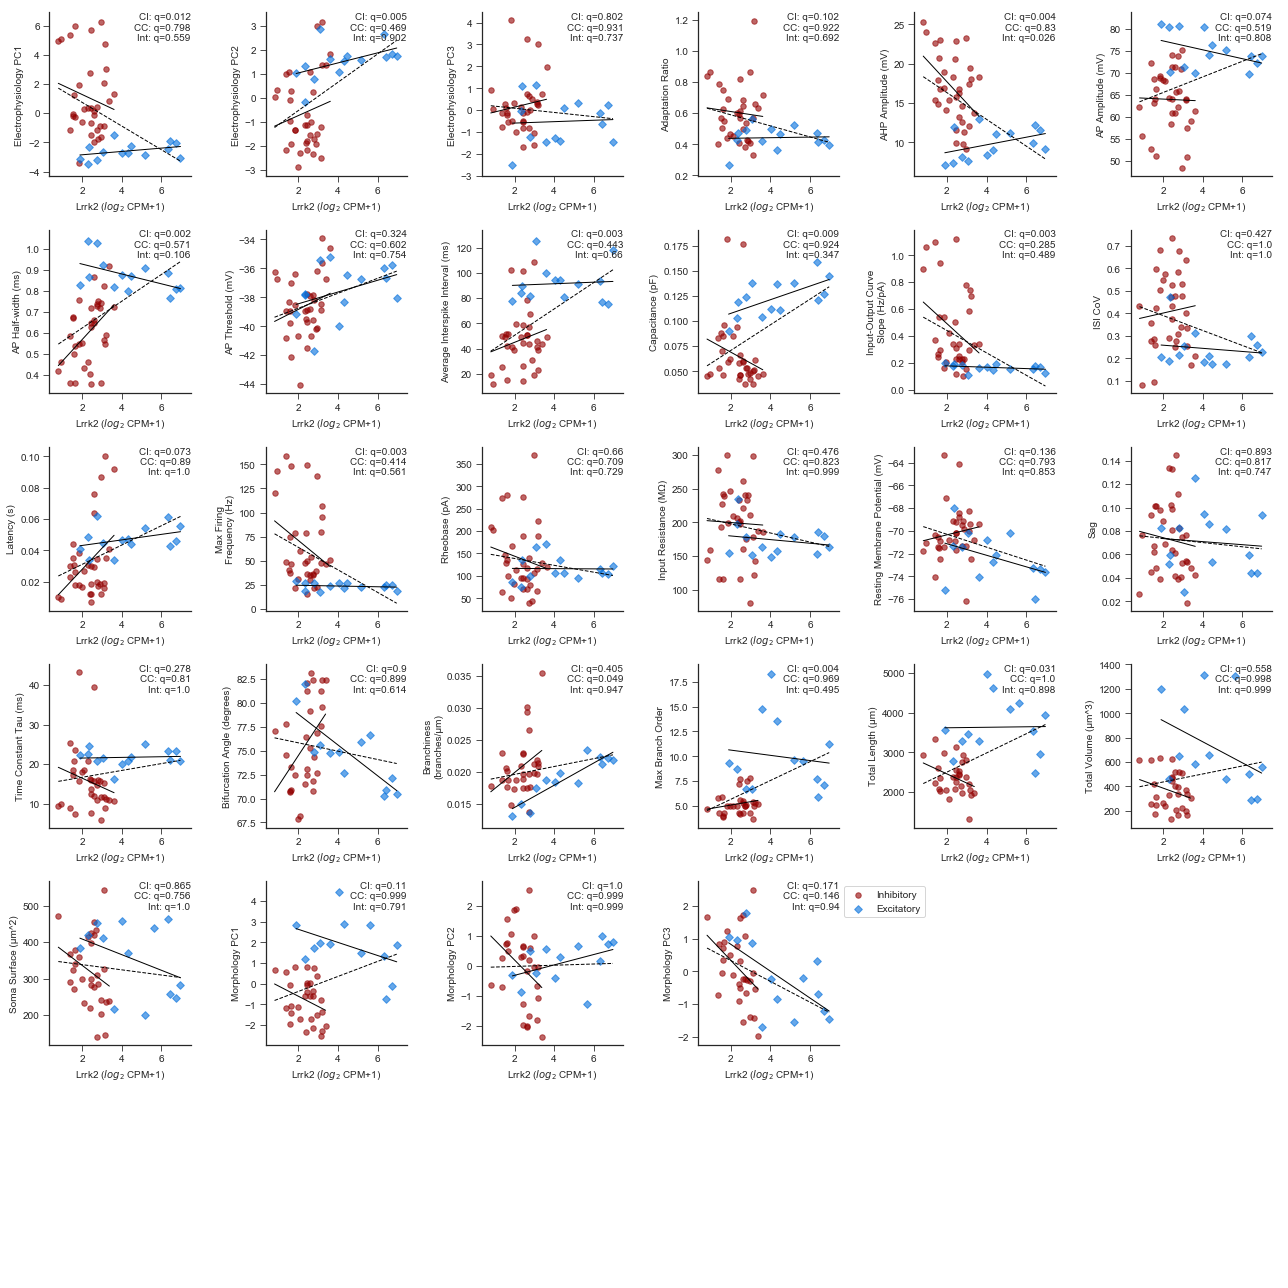

In [38]:
gene = 'Lrrk2'
measures = props_ephys + props_morph

genes = [gene] * len(measures)

# Set up axes
xy = int(math.ceil(np.sqrt(len(genes))))
fig, axes = plt.subplots(xy, xy, figsize = (xy * 3, xy * 3))

for gene, measure, ax in zip(genes, measures, axes.flat):
    make_scatter(gene, measure, ax)
make_legend(ax)
for ax in axes.flat[len(genes):]:
    ax.axis('off')   
fig.tight_layout()


plt.show()

# View summary data from models
This next section of cells will allow you to select rows to view based on gene name, ephys/morphology property, significance level, etc.

You can use Online Table 1 (`scores`) or 2 (`scores_all`) here. Table 1 includes only significant (FDR < 0.1 for either class-conditional or interaction models) results, and Table 2 includes all results. If filtering by number of significant properties for a given gene (last 3 cells in this section), you need to use Table 1.

First of all, we can get a sense of what our data looks like by viewing the first few rows:

In [40]:
scores.head()

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only,n_significant_0.1_g|c,n_significant_0.1_int
41,rmp,69784,1500009L16Rik,0.708612,0.612558,0.499698,0.675691,0.000375,0.001475,0.645879,...,210.951154,0.015980,0.064335,0.937694,0.675691,0.006259,149.559248,0.136095,9,4
53,rmp,73598,1700001O22Rik,-0.597760,-0.968526,-1.224694,-0.949696,0.025415,0.000119,0.766212,...,206.015919,0.145280,0.021072,0.960927,-0.949696,0.000314,143.615741,0.035590,13,1
235,rmp,373852,4833422C13Rik,1.439122,1.630314,0.972161,2.112861,0.003393,0.000281,0.175934,...,205.836114,0.047537,0.031437,0.853934,2.112861,0.000370,143.950604,0.037777,5,0
251,rmp,100041734,4930522L14Rik,2.650137,2.394161,1.227781,2.631460,0.000011,0.000034,0.317438,...,202.478079,0.002896,0.013290,0.883860,2.631460,0.000027,138.647386,0.011706,12,0
253,rmp,75833,4930532I03Rik,-1.979958,-1.919317,-2.328239,-1.797443,0.003323,0.002114,0.708880,...,211.742891,0.047179,0.076349,0.945608,-1.797443,0.014702,151.201312,0.196940,10,0


<b>Description of columns in Online Tables 1 and 2:</b>

- property: Ephys or morphology property  
- gene_entrez_id: Entrez Gene ID  
- gene_symbol : Official gene symbol  
- beta_gene: beta (slope) from the class-independent model  
- beta_gene|class: beta from the class-conditional model  
- slope_exc: excitatory cell type-specific slope from the interaction model  
- slope_inh: inhibitory cell type-specific slope from the interaction model  
- pval_gene: uncorrected p-value from the class-independent model       
- pval_gene|class_anova: uncorrected p-value from the class-conditional model  
- pval_int_anova: uncorrected p-value from the class-independent model    
- model1_aic: AIC (Akaike information criterion) goodness-of-fit measure, property ~ gene     
- model2_aic: AIC, property ~ cell class  
- model3_aic: AIC, property ~ gene + cell class  
- model4_aic: AIC, property ~ gene + cell class + gene * cell class interaction  
- FDR_gene: FDR-corrected p-value, class-independent (corresponds to pval_gene)  
- FDR_gene|class_anova: FDR-corrected p-value, class-conditional
- FDR_int_anova: FDR-corrected p-value, class-independent  
- n_significant_0.1_g|c: Total number of properties for which this gene shows FDR < 0.1 in the class-conditional model  (Online Table 1 only)  
- n_significant_0.1_int: Total number of properties for which this gene shows FDR < 0.1 in the interaction model (Online Table 1 only) 

Get all rows for your favorite gene:

In [41]:
scores_all[scores_all.gene_symbol == 'Camk2g']

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only
1606,rmp,12325,Camk2g,-0.951779,-0.782808,-1.604891,-0.645082,0.000263,9.629170e-03,0.249469,...,218.085394,212.857483,213.394144,0.013494,0.158027,0.869531,-0.645082,5.737857e-02,153.725986,0.385680
13816,apthr,12325,Camk2g,0.253007,0.055039,0.428989,-0.007609,0.282158,8.439367e-01,0.587610,...,207.008754,208.966954,210.642462,0.715652,0.976707,0.726420,-0.007609,9.807236e-01,150.591233,0.991697
26026,apamp,12325,Camk2g,0.269704,-2.700610,-1.089618,-2.970504,0.765115,7.737494e-04,0.384501,...,314.281248,304.092731,305.258304,0.844603,0.010159,0.597248,-2.970504,1.778345e-03,220.322580,0.012130
38236,aphw,12325,Camk2g,-0.005550,-0.084852,-0.054788,-0.089888,0.790171,1.496866e-07,0.373349,...,-52.592272,-80.336906,-79.211302,0.854434,0.000019,0.709106,-0.089888,3.788131e-06,-50.911069,0.000203
50446,ri,12325,Camk2g,-0.040887,-0.046468,-0.026071,-0.049886,0.000920,1.754548e-03,0.555914,...,-69.601584,-78.158843,-76.541522,0.015015,0.016021,0.974745,-0.049886,6.699936e-03,-46.566962,0.041022
62656,tau,12325,Camk2g,0.021061,-0.021182,-0.004929,-0.023904,0.302215,3.366624e-01,0.764148,...,-36.370842,-35.366463,-33.465793,0.503761,0.688551,0.999842,-0.023904,3.927961e-01,-14.438819,0.742826
74866,cap,12325,Camk2g,0.079360,0.028182,0.025018,0.028712,0.000155,1.450020e-01,0.946578,...,-48.314370,-48.605241,-46.610195,0.001170,0.357728,0.993398,0.028712,2.330251e-01,-25.017925,0.440853
87076,rheo,12325,Camk2g,0.060968,0.095604,-0.003141,0.112147,0.006359,2.773116e-04,0.095764,...,-12.980451,-25.232933,-26.294295,0.040420,0.003964,0.561542,0.112147,4.389123e-04,-11.975336,0.005267
99286,maxfreq,12325,Camk2g,0.027887,0.144821,0.025402,0.164827,0.388077,1.337542e-07,0.033371,...,-1.543280,-29.522458,-32.516559,0.503284,0.000006,0.291165,0.164827,1.103337e-06,-14.680032,0.000040
111496,ahpamp,12325,Camk2g,0.006257,0.072957,0.050665,0.076691,0.712380,5.153611e-09,0.373800,...,-74.173752,-108.960155,-107.832902,0.791102,0.000002,0.551042,0.076691,3.455902e-08,-79.258246,0.000002


Properties can be specified using one of the following abbreviations:

In [42]:
property_table

,Abbreviation
Input-Output Curve Slope,f_i_curve_slope
Morphology PC3,M_PC3
AP Half-width,aphw
Electrophysiology PC3,E_PC3
Time Constant Tau,tau
Max Branch Order,max_branch_order
Total Volume,total_volume
Soma Surface,soma_surface
Max Firing Frequency,maxfreq
Input Resistance,ri


In [43]:
# Get the row for your favorite gene and ephys or morphology property

scores_all[(scores_all.gene_symbol == 'Camk2g') & (scores_all.property == 'ahpamp')]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only
111496,ahpamp,12325,Camk2g,0.006257,0.072957,0.050665,0.076691,0.71238,5.153611e-09,0.3738,...,-74.173752,-108.960155,-107.832902,0.791102,0.000002,0.551042,0.076691,3.455902e-08,-79.258246,0.000002


You can also specify the gene using its Entrez Gene ID <b>without quotes</b>:

In [44]:
scores_all[(scores_all.gene_entrez_id == 12325) & (scores_all.property == 'ahpamp')]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only
111496,ahpamp,12325,Camk2g,0.006257,0.072957,0.050665,0.076691,0.71238,5.153611e-09,0.3738,...,-74.173752,-108.960155,-107.832902,0.791102,0.000002,0.551042,0.076691,3.455902e-08,-79.258246,0.000002


Get all rows for a given gene below a certain significance threshold in the class-conditional model

In [45]:
scores_all[(scores_all.gene_symbol == 'Camk2g') & (scores_all['FDR_gene|class_anova'] < 0.001)]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only
38236,aphw,12325,Camk2g,-0.005550,-0.084852,-0.054788,-0.089888,0.790171,1.496866e-07,0.373349,...,-52.592272,-80.336906,-79.211302,0.854434,0.000019,0.709106,-0.089888,3.788131e-06,-50.911069,0.000203
99286,maxfreq,12325,Camk2g,0.027887,0.144821,0.025402,0.164827,0.388077,1.337542e-07,0.033371,...,-1.543280,-29.522458,-32.516559,0.503284,0.000006,0.291165,0.164827,1.103337e-06,-14.680032,0.000040
111496,ahpamp,12325,Camk2g,0.006257,0.072957,0.050665,0.076691,0.712380,5.153611e-09,0.373800,...,-74.173752,-108.960155,-107.832902,0.791102,0.000002,0.551042,0.076691,3.455902e-08,-79.258246,0.000002
135916,f_i_curve_slope,12325,Camk2g,0.037831,0.152106,0.011372,0.175684,0.239489,6.809575e-08,0.012933,...,1.595023,-27.792218,-32.608190,0.339703,0.000003,0.177154,0.175684,3.224047e-07,-15.020746,0.000015
148126,avg_isi,12325,Camk2g,-0.008377,-0.108572,-0.022945,-0.122917,0.770158,1.144792e-05,0.112083,...,-15.761871,-34.519657,-35.305092,0.846250,0.000394,0.617046,-0.122917,6.388072e-05,-16.579988,0.001483
196966,E_PC1,12325,Camk2g,0.145532,1.247100,0.350698,1.397276,0.644139,5.185689e-06,0.129569,...,215.712197,195.322518,194.787467,0.742339,0.000110,0.439718,1.397276,4.800723e-05,147.264171,0.000627


Same thing, but this time using the interaction model:

In [46]:
scores_all[(scores_all.gene_symbol == 'Man1c1') & (scores_all['FDR_int_anova'] < 0.05)]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only
30753,apamp,230815,Man1c1,-2.220099,-1.806848,2.401055,-2.294072,1.846146e-05,1.244835e-05,2.403332e-05,...,314.281248,295.695813,278.019780,2.712569e-04,7.169542e-04,0.012758,-2.294072,1.845977e-07,201.548315,4.209542e-05
91803,rheo,230815,Man1c1,0.067070,0.068691,-0.063979,0.084053,1.394250e-07,1.570625e-07,7.569039e-06,...,-12.980451,-40.624856,-60.730914,3.700824e-05,2.372129e-05,0.010993,0.084053,4.834209e-09,-35.560919,5.152619e-06
116223,ahpamp,230815,Man1c1,0.042919,0.034255,-0.046628,0.043620,9.356138e-06,1.254342e-06,3.575607e-07,...,-74.173752,-97.499369,-124.072496,9.317981e-05,4.786098e-05,0.000406,0.043620,1.465630e-10,-90.708939,2.029972e-07
128433,adratio,230815,Man1c1,0.038585,0.034475,-0.032178,0.042193,1.269670e-06,2.992421e-06,1.908663e-04,...,-70.842239,-92.367691,-105.720801,8.279281e-05,4.567183e-04,0.031490,0.042193,6.721956e-08,-73.734020,6.048087e-05
201693,E_PC1,230815,Man1c1,1.031775,0.905303,-0.345174,1.050093,2.179830e-10,8.736721e-13,1.190646e-07,...,215.712197,162.645050,133.729535,1.762630e-08,4.848880e-10,0.000162,1.050093,3.545878e-14,103.276716,1.367290e-10


Select only genes with a significant result in the class-conditional model but NOT the class-independent model  
Here we're using thresholds of < 0.01 and > 0.1, respectively  
Also in this example filtering by property

In [47]:
scores_all[(scores_all['FDR_gene|class_anova'] < 0.01) & (scores_all['FDR_gene'] > 0.1) & (scores_all.property == 'aphw')]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only
36654,aphw,73747,1110034G24Rik,-0.086470,-0.135463,-0.101152,-0.149449,0.121521,7.552703e-04,0.564707,...,-52.592272,-62.829181,-61.195079,0.217689,0.006841,0.818549,-0.149449,5.652397e-03,-36.131360,0.025522
36666,aphw,544717,1190007I07Rik,-0.053580,-0.114374,-0.000841,-0.140834,0.207234,1.969026e-04,0.050894,...,-52.592272,-65.537537,-67.742975,0.328084,0.002636,0.401739,-0.140834,1.556424e-04,-43.296022,0.002270
36689,aphw,75549,1700019L22Rik,0.023951,0.108750,0.059133,0.126684,0.481901,1.833220e-05,0.191878,...,-52.592272,-70.382223,-70.261356,0.608418,0.000529,0.589379,0.126684,1.238030e-04,-43.760788,0.001967
36690,aphw,66602,1700020I14Rik,-0.047621,-0.082009,-0.036709,-0.086142,0.087728,3.321222e-05,0.447901,...,-52.592272,-69.163642,-67.799131,0.169513,0.000766,0.750660,-0.086142,1.779067e-04,-43.024856,0.002492
36704,aphw,74284,1700086L19Rik,-0.009952,-0.030322,-0.008673,-0.032517,0.421493,9.332609e-04,0.426697,...,-52.592272,-62.405978,-61.103078,0.553023,0.007809,0.739953,-0.032517,2.454414e-03,-37.766707,0.014643
36708,aphw,73571,1700096K18Rik,-0.049465,-0.177246,-0.000800,-0.246338,0.462347,3.955496e-04,0.015311,...,-52.592272,-64.128270,-68.615677,0.591560,0.004299,0.279903,NaN,NaN,NaN,NaN
36739,aphw,233545,2210018M11Rik,-0.050310,-0.075300,-0.058385,-0.077838,0.111148,9.306788e-04,0.761562,...,-52.592272,-62.411512,-60.513099,0.203404,0.007809,0.914969,-0.077838,4.611337e-03,-36.528234,0.022117
36742,aphw,73652,2210408F21Rik,0.010602,-0.073228,0.031837,-0.083371,0.685047,6.879208e-04,0.104707,...,-52.592272,-63.016276,-63.920566,0.778262,0.006422,0.499193,-0.083371,8.218426e-04,-39.941631,0.007032
36756,aphw,381792,2310040G24Rik,0.025740,-0.098644,-0.046405,-0.168848,0.467593,1.174305e-03,0.031739,...,-52.592272,-61.947613,-65.036471,0.595967,0.009098,0.348343,NaN,NaN,NaN,NaN
36763,aphw,69659,2310069G16Rik,-0.057889,-0.072980,0.008903,-0.086236,0.053402,6.873521e-04,0.100239,...,-52.592272,-63.017933,-63.998781,0.115712,0.006421,0.493730,-0.086236,7.278665e-04,-40.184727,0.006435


You can also filter according to the number of properties a gene is associated with. This was calculated at a threshold of FDR < 0.1 in Online Table 1, for both class-conditional and interaction models.  

All genes uniquely associated with a single property (class-conditional):

In [48]:
scores[scores['n_significant_0.1_g|c'] == 1]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only,n_significant_0.1_g|c,n_significant_0.1_int
1149,rmp,11928,Atp1a1,-0.959806,-1.001250,-2.027266,-0.817439,2.389484e-05,0.001484,0.143885,...,208.838735,0.004421,0.064382,0.853277,-0.817439,0.022252,151.984343,0.243531,1,0
3271,rmp,66366,Ergic3,2.408950,2.398989,1.652877,3.015125,4.017062e-05,0.002562,0.372562,...,211.399191,0.005814,0.081032,0.889616,3.015125,0.006009,149.479978,0.135229,1,0
3623,rmp,72514,Fgfbp3,-1.748133,-1.654428,-1.578486,-1.695284,6.281292e-04,0.000499,0.901128,...,208.999395,0.020955,0.040074,0.986318,-1.695284,0.005527,149.317357,0.128702,1,0
3737,rmp,14337,Ftl2,2.246192,2.100935,1.441547,2.560410,3.786592e-05,0.002260,0.402248,...,211.254936,0.005756,0.077204,0.895955,2.560410,0.005097,149.159643,0.124896,1,0
4553,rmp,546015,Gm5905,3.708753,3.164402,2.058595,3.987934,9.077116e-05,0.003477,0.358027,...,211.945359,0.008090,0.094975,0.885383,3.987934,0.006191,149.537990,0.136095,1,0
6323,rmp,67075,Magt1,1.399193,2.942856,3.498238,2.586623,9.043814e-02,0.000275,0.556685,...,207.432826,0.292693,0.031317,0.924577,2.586623,0.018583,151.645225,0.221162,1,0
9808,rmp,11989,Slc7a3,0.828585,0.717890,0.865224,0.673761,2.169986e-05,0.000309,0.665579,...,207.842971,0.004206,0.032487,0.941543,0.673761,0.004207,148.785048,0.115063,1,0
12460,apthr,71653,4930506M07Rik,-1.097762,-1.124850,-1.677580,-1.031049,5.495390e-05,0.000270,0.429792,...,196.015160,0.055916,0.099935,0.596775,-1.031049,0.003219,141.228469,0.127952,1,0
15134,apthr,319901,Dsel,-0.841323,-1.367161,-1.629244,-1.256342,5.530424e-03,0.000015,0.550568,...,190.361971,0.254073,0.022326,0.697508,-1.256342,0.001810,140.092616,0.109143,1,0
22917,apthr,69195,Tmem121,-1.774734,-1.704232,-1.478080,-1.886933,4.026214e-05,0.000072,0.607498,...,193.716614,0.055916,0.054654,0.740813,-1.886933,0.001927,140.216259,0.112019,1,0


That's a lot of genes; maybe we want to further filter by significance level:

In [49]:
scores[(scores['n_significant_0.1_g|c'] == 1) & (scores['FDR_gene|class_anova'] <= 0.001)]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only,n_significant_0.1_g|c,n_significant_0.1_int
38497,aphw,241201,Cdh7,-0.102824,-0.075639,-0.065239,-0.076142,3.478797e-10,0.000045,0.893177,...,-66.554112,5.117604e-08,0.000942,0.962088,-0.076142,0.000342,-41.700582,0.003861,1,0
38669,aphw,108699,Chn1,0.045614,-0.128481,-0.059134,-0.136619,1.206675e-01,0.000024,0.390205,...,-68.619627,2.167463e-01,0.000620,0.720971,-0.136619,0.000135,-43.582505,0.002065,1,0
44376,aphw,241489,Pde11a,0.022897,0.061477,0.032041,0.061518,2.302697e-01,0.000008,0.929043,...,-70.178061,3.542387e-01,0.000288,0.976807,0.061518,0.000058,-45.316429,0.001183,1,0


Less stringent unique-ness threshold (fewer than 4 properties sharing a gene), more stringent significance threshold:

In [50]:
scores[(scores['n_significant_0.1_g|c'] < 4) & (scores['FDR_gene|class_anova'] <= 0.000001)]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only,n_significant_0.1_g|c,n_significant_0.1_int
73637,cap,442803,A830005F24Rik,0.117982,0.157682,0.010755,0.162824,2.480841e-03,3.738218e-11,0.132254,...,-93.955432,1.026726e-02,6.533460e-08,0.625848,0.162824,1.452694e-09,-62.919688,0.000002,2,0
73863,cap,11513,Adcy7,0.066193,0.131414,0.073343,0.135100,4.738504e-02,4.731852e-10,0.384777,...,-86.946717,1.030403e-01,4.570816e-07,0.835450,0.135100,3.994614e-08,-55.983327,0.000016,2,0
75671,cap,73720,Cst6,0.106096,0.101405,0.040414,0.108258,3.557553e-17,4.024911e-10,0.109604,...,-89.277808,4.343773e-13,4.570816e-07,0.592797,0.108258,1.510664e-08,-58.015144,0.000010,3,0
77376,cap,667373,Gm14446,0.139052,0.131944,0.045130,0.141591,2.514444e-05,6.300612e-10,0.086324,...,-88.756990,2.798666e-04,4.859725e-07,0.548636,0.141591,1.633650e-08,-57.851490,0.000010,2,0
79685,cap,17174,Masp1,0.054528,0.075229,0.039205,0.079273,3.383443e-03,3.745636e-11,0.166762,...,-93.560656,1.302497e-02,6.533460e-08,0.670178,0.079273,4.217015e-09,-60.685795,0.000004,3,0
80836,cap,18430,Oxtr,0.017665,0.065405,-0.217200,0.066021,2.741301e-01,1.188141e-09,0.125049,...,-86.775033,3.957352e-01,8.059555e-07,0.614078,0.066021,4.820819e-08,-55.590882,0.000018,2,0


Filter for genes showing a highly significant interaction with exactly one property:

In [51]:
scores[(scores['n_significant_0.1_int'] == 1) & (scores['FDR_int_anova'] <= 0.001)]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only,n_significant_0.1_g|c,n_significant_0.1_int
110777,ahpamp,74385,Ap5m1,0.040109,0.065896,-0.094000,0.093323,9.620841e-02,0.000088,1.256387e-06,...,-112.669982,1.688765e-01,0.000869,0.000723,0.093323,4.783151e-08,-78.579684,2.754994e-06,10,1
112391,ahpamp,114886,Cygb,0.050528,0.028896,-0.054415,0.064434,3.940729e-08,0.023613,6.834340e-07,...,-102.894481,1.279053e-06,0.052441,0.000596,0.064434,9.544660e-06,-67.591543,9.785131e-05,4,1
114934,ahpamp,231123,Haus3,-0.026935,0.057760,-0.088437,0.122604,3.475342e-01,0.015211,2.222299e-06,...,-101.223143,4.648764e-01,0.037430,0.000964,0.122604,7.033847e-06,-68.220295,7.861598e-05,8,1
119553,ahpamp,20511,Slc1a2,-0.036704,-0.030291,0.037203,-0.039156,1.237791e-12,0.000002,5.931801e-07,...,-122.248684,6.297262e-10,0.000060,0.000557,-0.039156,1.947284e-10,-90.111638,2.029972e-07,11,1
78272,cap,14998,H2-DMa,0.111876,0.047534,-0.036779,0.202943,1.147409e-05,0.058550,7.522259e-08,...,-80.068544,1.511312e-04,0.218544,0.000230,0.202943,1.156854e-06,-48.979169,1.760854e-04,0,1


In [52]:
scores[(scores.gene_symbol == 'Chn1') & (scores.property == 'aphw')]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only,n_significant_0.1_g|c,n_significant_0.1_int
38669,aphw,108699,Chn1,0.045614,-0.128481,-0.059134,-0.136619,0.120667,0.000024,0.390205,...,-68.619627,0.216746,0.00062,0.720971,-0.136619,0.000135,-43.582505,0.002065,1,0


# Scatter plots
Create scatter plots for one or more combinations of gene + ephys or morphology property

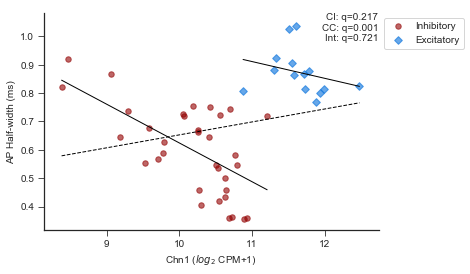

In [53]:
# Scatter plot for a single gene and property
# This example of one of the highly significant, unique genes from a couple of examples above

gene = 'Chn1'
measure = 'aphw'

make_scatter(gene, measure)
make_legend(plt.gca())

plt.show()

<b>Customizing the scatter plot</b>  
alpha: Transparency of the points (0 to 1, default is 0.6)  
s: Size of the points (default is 30)  
log: plot on log scale (True) or linear (False; default)  
annotate_qvals: Show the q-values on the plot (default True)

The line starting with "fig, ax..." allows you to set the figure size.

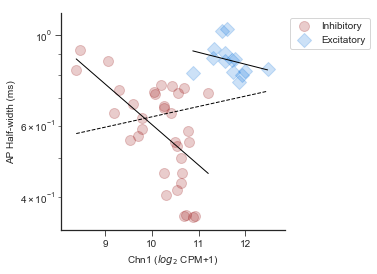

In [54]:
gene = 'Chn1'
measure = 'aphw'
fig, ax = plt.subplots(figsize = (4, 4))
make_scatter(gene, measure, ax, alpha = 0.2, s = 100, log = True, annotate_qvals = False)
make_legend(ax, alpha = 0.2, s = 100)
plt.show()

You can also enter the gene using its Entrez ID <b>(without quotes)</b>

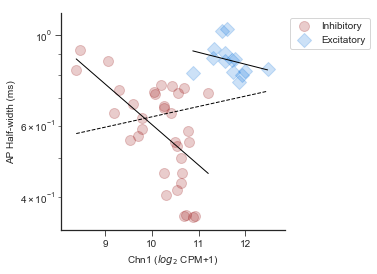

In [55]:
gene = 108699
measure = 'aphw'
fig, ax = plt.subplots(figsize = (4, 4))
make_scatter(gene, measure, ax, alpha = 0.2, s = 100, log = True, annotate_qvals = False)
make_legend(ax, alpha = 0.2, s = 100)
plt.show()

# Plotting multiple genes on a grid
You might want to visualize several gene/property relationships at once. The following shows several examples of how you can specify one gene + several properties or vice versa, or several of each. This is the same as what we did in the first example, only now you can specify the gene-property pairs in whichever way you like (ie you're not limited to just plotting one gene against all the properties in the list).  

We're going to pick the genes and properties by setting two variables, called `genes` and `measures`.

Run the cell with the genes + properties you want, then skip to the plotting cell at the end of this section (don't run the cells in between; you will end up plotting just the genes + properties from the last cell you ran).

Plot one gene against several properties:

In [56]:
genes = 'Lrrk2'
measures = props_morph

`props_morph`, `props_ephys`, and `props_all` (<b>without quotes</b>) will let you plot every property in a given category. Or specify the exact properties you want (see table above):

In [57]:
genes = 'Chn1'
measures = ['aphw', 'ahpamp', 'ri', 'rheo', 'adratio', 'apamp', 'maxfreq', 'avg_isi']

Plot several genes against one property:

In [58]:
genes = ['BC048546', 'Pcdh9', 'Bach1', 'Tubb5', 'Fxyd6', 'Slc8a2']
measures = 'ahpamp'

Plot several genes against several different properties - in this case ahpamp for the first 3, then aphw for the next 3

The number of genes should match the number of properties (including repeats):

In [59]:
genes = ['BC048546', 'Pcdh9', 'Bach1', 'Tubb5', 'Fxyd6', 'Slc8a2']
measures = ['ahpamp'] * 3 + ['aphw'] * 3

For more flexibility, this could also be written as:

In [60]:
genes = ['BC048546', 'Pcdh9', 'Bach1', 'Tubb5', 'Fxyd6', 'Slc8a2']
measures = ['ahpamp', 'ahpamp', 'ahpamp', 'aphw', 'aphw', 'aphw']

You can also pick genes to plot according to some combination of significance thresholds (similar to how we selected rows in the previous section).  
Be careful; you probably don't want to plot 1000 genes at once. Here we've set a threshold so that we only plot the top 25 genes if there are more than that.

In this case, we're looking for genes that are 1) highly significant in the class-conditional model and 2) non-significant in the interaction model for the property AHP amplitude.

In [61]:
measures = 'ahpamp'
genes = list(scores_all[(scores_all['FDR_gene|class_anova'] < 0.00001) &      # Only pick rows where FDR < 0.000001
                (scores_all['FDR_int_anova'] > 0.1) &                         # Only pick rows where FDR_int > 0.1
                (scores_all.property == measures)]['gene_symbol'])            # Only pick rows where the property is ahpamp

print('Total genes: ', len(genes))
threshold = 25
if len(genes) > threshold:
    genes = genes[:threshold]

Total genes:  120


Similar to above example, but not limited to one property

Also limiting to only relationships with negative slopes (class-conditional as well as class-specific slopes)

In [62]:
rows = scores_all[(scores_all['FDR_gene|class_anova'] < 0.000001) & 
          (scores_all['beta_gene|class'] < 0) &
          (scores_all['slope_exc'] < 0) &
          (scores_all['slope_inh'] < 0) &
          (scores_all['FDR_int_anova'] > 0.1)]
genes = list(rows['gene_symbol'])
measures = list(rows['property'])

print('Total genes: ', len(genes))
threshold = 25
if len(genes) > threshold:
    genes = genes[:threshold]
    measures = measures[:threshold]

Total genes:  88


Relationships with a significant interaction term, where the slopes in E and I types are different (ie, there might actually be an opposite relationship, as opposed to just no relationship in one class)

As you can see from the plots, this is just a very coarse way of filtering; one class can have a strong slope and the other can have a very weak slope in the opposite direction.

In [63]:
rows = scores_all[(np.sign(scores_all['slope_exc']) != np.sign(scores_all['slope_inh'])) &  # Only pick rows where signs of slope_exc and slope_inh do not match 
          (scores_all['FDR_int_anova'] < 0.001)]
genes = list(rows['gene_symbol'])
measures = list(rows['property'])

print('Total genes: ', len(genes))
threshold = 25
if len(genes) > threshold:
    genes = genes[:threshold]
    measures = measures[:threshold]

Total genes:  58


There's a lot going on there, but running one of the 3 cells directly above just sets the values of `genes` and `measures` according to the criteria specified. We can check the output before plotting:

In [64]:
print(genes)
print(measures)

['Hes1', 'Galnt14', 'Gm336', 'Hes1', 'Rims3', 'Gm6788', 'Rasl10a', 'Ankrd35', 'Ccdc113', 'Gstm5', 'H2-DMa', 'Kctd4', 'Rora', 'S100a6', 'Sema4a', 'Gm19410', 'Slc8a2', '2300009A05Rik', 'Ap5m1', 'Arl15', 'Atp6v1g2', 'Cadm4', 'Cdk18', 'Coa7', 'Cygb']
['apamp', 'ri', 'ri', 'ri', 'ri', 'tau', 'tau', 'cap', 'cap', 'cap', 'cap', 'cap', 'cap', 'cap', 'cap', 'maxfreq', 'maxfreq', 'ahpamp', 'ahpamp', 'ahpamp', 'ahpamp', 'ahpamp', 'ahpamp', 'ahpamp', 'ahpamp']


# Run this cell to plot:

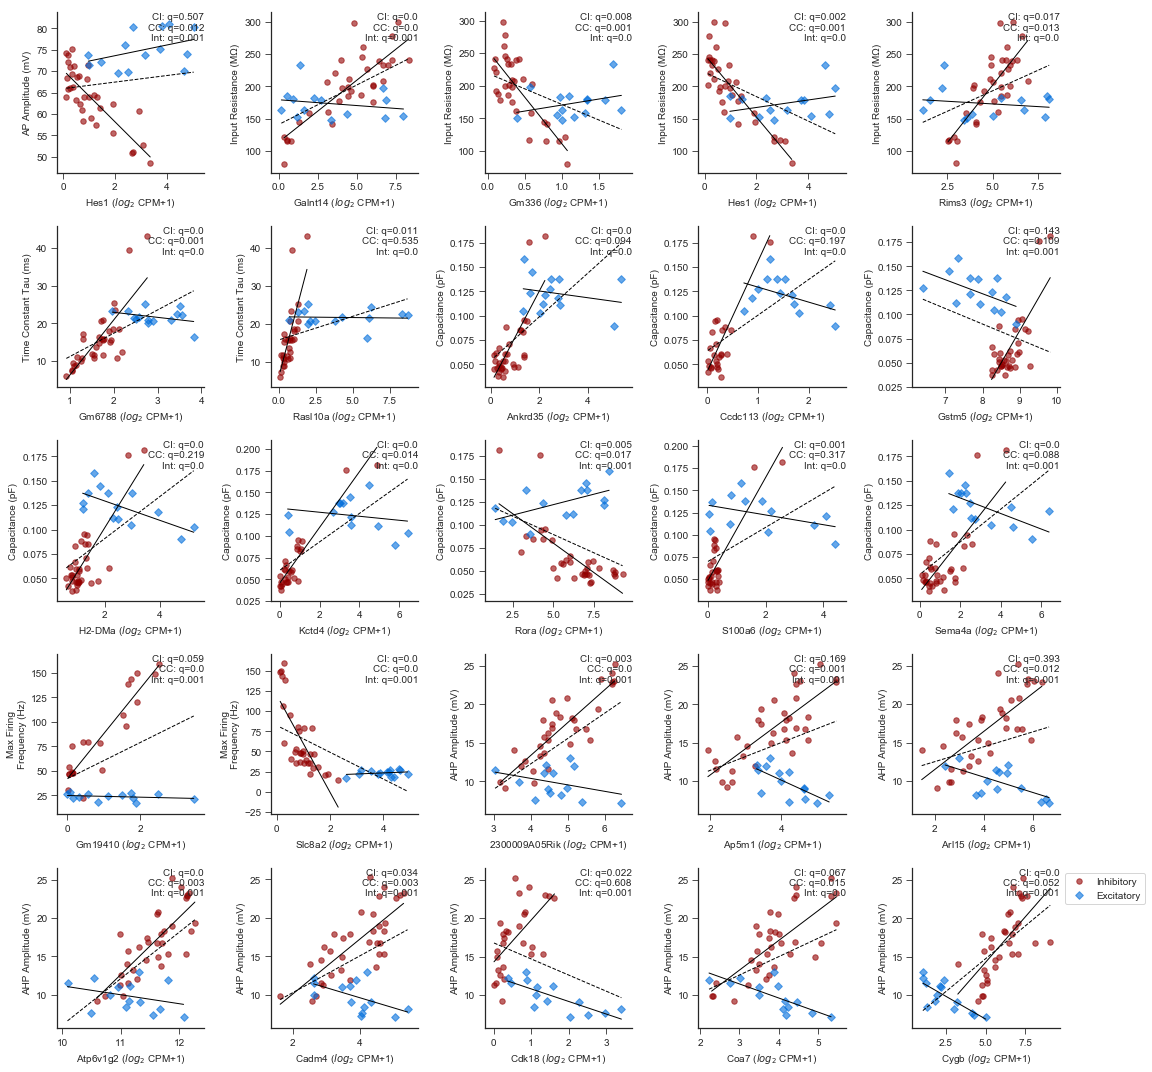

In [65]:
if (type(genes) != list) & (type(measures) == list):
    genes = [genes] * len(measures)
elif (type(measures) != list) & (type(genes) == list):
    measures = [measures] * len(genes)
elif (type(measures) != list) & (type(genes) != list):
    print('Either "genes" or "measures" needs to be provided as a list')
    print('For example:\ngenes = ["BC048546", "Pcdh9", "Bach1"]')

# Set up axes
xy = int(math.ceil(np.sqrt(len(genes))))
fig, axes = plt.subplots(xy, xy, figsize = (xy * 3, xy * 3))
# This will automatically pick the number of axes and the figure size
# If you want to set this yourself, you can do something like this (remove # to run the line below):
# fig, axes = plt.subplots(2, 3, figsize = (8, 6))

for gene, measure, ax in zip(genes, measures, axes.flat):
    make_scatter(gene, measure, ax)
make_legend(ax)
for ax in axes.flat[len(genes):]:
    ax.axis('off')   
fig.tight_layout()


plt.show()

# See the full model output for a gene + property

If you want to see the full model results rather than just the summary data in Online Tables 1 and 2, you can re-run the models for a specific gene/property pair.

Enter your gene of interest and ephys/morphology property


In [66]:
measure = 'rmp'
gene = 'Camk2g'

This will give some warnings on the ANOVA step. This seems to not be an actual problem, just an issue with how statsmodels handles warnings:

https://github.com/statsmodels/statsmodels/issues/4974

In [67]:
output = fit_models(gene, measure, ephys)

//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


The properties 'total_length', 'cap', 'latency', 'max_branch_order', 'total_volume', 'f_i_curve_slope', 'rheo', 'maxfreq', 'adratio', 'ri', 'branchiness', 'isi_cv', 'avg_isi', 'tau', 'sag', and 'ahpamp' were log10-transformed before running models. You can run the models with or without, but they will match our data only if you use the log transform.

Add "_log10" to the property name in order to use the log-transformed values.

In [68]:
gene = 'Lrrk2'
measure = 'branchiness_log10'

We've saved Online Table 3 under the name `ephys`, and 4 under the name `morph`. You'll need to specify the table that corresponds to the property you're looking at.

In [69]:
output = fit_models(gene, measure, morph)

//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Our output is made up of 7 different tables. Run this cell to split it into individual variables:

In [70]:
res1, res2, res3, res4, a1, a2, df = output

It's a good idea to check whether your summary results match those in Online Table 2.

Summary table from the models you just ran:

In [71]:
df

,property,gene_entrez_id,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic
0,branchiness_log10,66725,0.014206,0.042786,0.041847,0.045651,0.11168,0.000134,0.873661,-88.737999,-88.186658,-102.056228,-100.084465


The corresponding slice from Online Table 2:

In [72]:
scores_all[(scores_all.gene_symbol == gene) & (scores_all.property == measure.replace('_log10', ''))]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,...,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,beta_gene_inh_only,pval_gene_inh_only,inh_only_aic,FDR_gene_inh_only
30385,branchiness,66725,Lrrk2,0.014206,0.042786,0.041847,0.045651,0.11168,0.000134,0.873661,...,-88.186658,-102.056228,-100.084465,0.405001,0.048543,0.947268,0.045651,0.060746,-63.081727,0.591827


View the complete model outputs

In [73]:
# class-independent model (property~gene)

res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      branchiness_log10   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.643
Date:                Sat, 25 May 2019   Prob (F-statistic):              0.112
Time:                        09:56:05   Log-Likelihood:                 46.369
No. Observations:                  43   AIC:                            -88.74
Df Residuals:                      41   BIC:                            -85.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7447      0.029    -59.207      0.000      -1.804      -1.685
Gene66725      0.0142      0.009      1.626      0.112      -0.003       0.032
==============================================================================
Omnibus:                        6.694   Durbin-Watson:                   2.257
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                5.939
Skew:                           0.615   Prob(JB):                       0.0513
Kurtosis:                       4.342   Cond. No.                         8.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
# property ~ class

res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      branchiness_log10   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.087
Date:                Sat, 25 May 2019   Prob (F-statistic):              0.156
Time:                        09:56:05   Log-Likelihood:                 46.093
No. Observations:                  43   AIC:                            -88.19
Df Residuals:                      41   BIC:                            -84.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.7300      0.024    -73.528      0.000      -1.778      -1.682
C(cell_class)[T.inh]     0.0407      0.028      1.445      0.156      -0.016       0.098
==============================================================================
Omnibus:                        3.162   Durbin-Watson:                   2.346
Prob(Omnibus):                  0.206   Jarque-Bera (JB):                2.026
Skew:                           0.422   Prob(JB):                        0.363
Kurtosis:                       3.648   Cond. No.                         3.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
# Class-conditional model (property ~ gene + class)

res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      branchiness_log10   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     10.40
Date:                Sat, 25 May 2019   Prob (F-statistic):           0.000231
Time:                        09:56:05   Log-Likelihood:                 54.028
No. Observations:                  43   AIC:                            -102.1
Df Residuals:                      40   BIC:                            -96.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9251      0.050    -38.323      0.000      -2.027      -1.824
C(cell_class)[T.inh]     0.1342      0.032      4.137      0.000       0.069       0.200
Gene66725                0.0428      0.010      4.226      0.000       0.022       0.063
==============================================================================
Omnibus:                        5.924   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.538
Skew:                           0.478   Prob(JB):                       0.0627
Kurtosis:                       4.475   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
# Interaction model (property ~ gene + class + gene*class)

res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      branchiness_log10   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     6.773
Date:                Sat, 25 May 2019   Prob (F-statistic):           0.000872
Time:                        09:56:05   Log-Likelihood:                 54.042
No. Observations:                  43   AIC:                            -100.1
Df Residuals:                      39   BIC:                            -93.04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.9208      0.057    -33.423      0.000      -2.037      -1.805
C(cell_class)[T.inh]               0.1231      0.077      1.606      0.116      -0.032       0.278
Gene66725                          0.0418      0.012      3.542      0.001       0.018       0.066
Gene66725:C(cell_class)[T.inh]     0.0038      0.024      0.160      0.874      -0.044       0.052
==============================================================================
Omnibus:                        5.466   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                4.952
Skew:                           0.444   Prob(JB):                       0.0841
Kurtosis:                       4.406   Cond. No.                         32.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
# We presented the class-conditional model in the manuscript in terms of the effects of the gene on the property
    # after removing the effects of class (property ~ gene | class)
# This was done by comparing the model above with the property ~ class model using an ANOVA

a1

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,41.0,0.295067,0.0,NaN,NaN,NaN
1,40.0,0.204005,1.0,0.091062,17.854962,0.000134


In [78]:
# The class-conditional model is similar: We used an ANOVA to isolate just the interaction effect

a2

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,40.0,0.204005,0.0,NaN,NaN,NaN
1,39.0,0.203871,1.0,0.000134,0.025619,0.873661
